#### Simplex method

In [8]:
import numpy as np


def simplex(A, b, c, x):
    A = A.transpose()
    bAx = b - np.dot(A, x)
    j = np.where(bAx == 0)[0]
    while True:
        print (j)
        zj = -np.dot(A[j], c)
        if zj.min() >= 0:
            return "solution: " + str(x)
        k = np.argmin(zj)
        temp = np.zeros(np.shape(j))
        temp[k] = -1
        dx = np.linalg.solve(A[j], temp)
        indexes = np.where(np.dot(A, dx) > 0)
        if not indexes:
            return "-inf"
        bAxi = b[indexes] - np.dot(A[indexes], x)
        Adxi = np.dot(A[indexes], dx)
        res = bAxi / Adxi
        alpha = res.min()
        i = np.array(indexes[0][res.argmin()])
        x += alpha * dx
        j = np.delete(j, k)
        j = np.append(j, i)


A = np.array(
    [[-1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0], [0.0, -1.0, 0.0, 0.0, 1.0, 0.0, 1.0], [0.0, 0.0, -1.0, 0.0, 0.0, 1.0, 1.0]])
b = np.array([0.0, 0.0, 0.0, 2.0, 2.0, 2.0, 5.0])
c = np.array([1.0, 1.0, -1.0])
x = np.array([2.0, 2.0, 0.0])
print (simplex(A, b, c, x))


[2 3 4]
[3 4 6]
[4 6 5]
[6 5 3]
[5 3 1]
[5 1 0]
solution: [0. 0. 2.]


#### Ellipsoid method

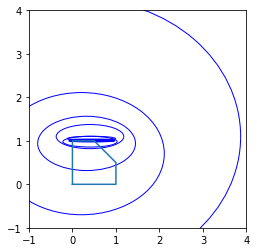

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def ellipsoid_method(A, b, c, x0, R, eps):
    res = [x0]
    radius=[R]
    
    A = A.transpose()
    n = len(c)
    H = np.identity(n) * R ** 2
    x_prev = x0
    while True:
        if ((np.matmul(A, x_prev) - b) <= 0).all():
            w = c
        else:
            w = A[np.where((np.dot(A, x_prev) - b) > 0)][0]
        x_new = x_prev - (1 / (n + 1)) * (np.dot(H, w) / np.sqrt(np.dot(np.dot(w.transpose(), H), w)))
        H = ((n ** 2) / ((n ** 2) - 1)) * (H - (2. / (n + 1)) * (np.dot(np.dot(np.dot(H, w), w.transpose()), H) / np.dot(np.dot(w.transpose(), H), w)))
        res.append(x_new)
        radius.append(H[0,0])
        if np.linalg.norm(x_prev - x_new) < eps:
            break
        x_prev = x_new
    return res, radius

A = np.array([[-1.0, 1.0, 0.0, 0.0, 1.0], [0.0, 0.0, -1.0, 1.0, 1.0]])
b = np.array([0.0, 1.0, 0.0, 1.0, 1.5])
c = np.array([-1.0, -2.0])
x = np.array([0.5, 0.5])
R = 4
eps = 10e-11

res, radius = ellipsoid_method(A, b, c, x, R, eps)


fig, ax = plt.subplots()
ax.set_aspect("equal")

import math 
plt.xlim(-1, 4)
plt.ylim(-1,4)
ax.plot([0, 0, 0.5, 1, 1, 0], [0, 1, 1, 0.5, 0, 0])
ells=[]
for i in range(2,15):
        elip=Ellipse(xy=res[i+1],height=abs(radius[i])*2,width=1+abs(radius[i])*2,angle=0,edgecolor='b',
                    lw=1,facecolor='none')
        ells.append(elip)
for e in ells:
    ax.add_artist(e)
plt.show()

###### CVX for LP

In [11]:
from cvxopt import matrix, solvers
A = matrix([[-1.0, 1.0, 0.0, 0.0, 1.0], [0.0, 0.0, -1.0, 1.0, 1.0]])
b = matrix([0.0, 1.0, 0.0, 1.0, 1.5])
c = matrix([-1.0, -2.0])
sol=solvers.lp(c,A,b)

     pcost       dcost       gap    pres   dres   k/t
 0: -1.8750e+00 -7.5625e+00  4e+00  0e+00  1e+00  1e+00
 1: -2.2490e+00 -2.9066e+00  4e-01  1e-16  1e-01  9e-02
 2: -2.4873e+00 -2.5424e+00  3e-02  3e-16  1e-02  7e-03
 3: -2.4999e+00 -2.5004e+00  3e-04  1e-16  1e-04  7e-05
 4: -2.5000e+00 -2.5000e+00  3e-06  5e-16  1e-06  7e-07
 5: -2.5000e+00 -2.5000e+00  3e-08  3e-16  1e-08  7e-09
Optimal solution found.


In [12]:
print(sol['x'])

[ 5.00e-01]
[ 1.00e+00]



In [13]:
import cvxpy as cvx
n = 2
X = cvx.Variable( (n, n), PSD=True )
constraints = [X >> 1/2 * np.eye(n), X << np.eye(n)]

C = np.random.rand(n,n)
obj = cvx.Minimize(cvx.trace(C * X)) # Matrix class dot product
pr2 = cvx.Problem(obj, constraints)

pr2.solve(solver=cvx.CVXOPT)

print(pr2.status, pr2.value)
print(X.value)

optimal -5.35078111788272
[[ 0.55478284 -0.15617375]
 [-0.15617375  0.94521722]]


#### CVX for SDP

In [19]:
x = []
y = []
z = []

for i in range(500):
    n = 2
    X = cvx.Variable( (n, n), PSD=True )
    C = np.random.normal(size = (n, n))
    constraints = [X >> 1/2 * np.eye(n), X << np.eye(n)]
    obj = cvx.Minimize(cvx.trace(C * X)) # Matrix class dot product
    pr = cvx.Problem(obj, constraints)
    pr.solve(solver=cvx.CVXOPT)
    x.append(X.value[0,0])
    y.append(X.value[1,1])
    z.append(X.value[0,1])
  
  
x = np.array(x)
y = np.array(y)
z = np.array(z)

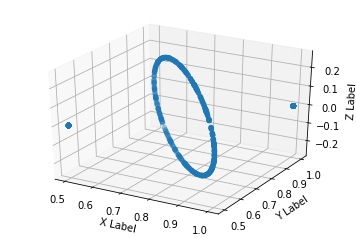

In [20]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y , z)


ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()